# Analying metadata of posters on Zenodo and Figshare

## Imports

In [1]:
import json
import os
import time
from datetime import datetime
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from matplotlib.patches import Patch
import re
from urllib.parse import unquote
from collections import Counter
import re
from urllib.parse import urlparse


In [ ]:
sns.set(
    font="Franklin Gothic Book",
    rc={
        "axes.axisbelow": False,
        "axes.edgecolor": "lightgrey",
        "axes.facecolor": "None",
        "axes.grid": False,
        "axes.labelcolor": "dimgrey",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "figure.facecolor": "white",
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": "dimgrey",
        "xtick.bottom": False,
        "xtick.color": "dimgrey",
        "xtick.direction": "out",
        "xtick.top": False,
        "ytick.color": "dimgrey",
        "ytick.direction": "out",
        "ytick.left": False,
        "ytick.right": False,
    },
)
sns.set_context(
    "notebook", rc={"font.size": 16, "axes.titlesize": 20, "axes.labelsize": 18}
)

colors = ["#073b4c", "#ffd166", "#06d6a0", "#118ab2", "#ef476f", "#fb5607"]
patterns = ["/", "\\", "-", "+", "x", "o", "O", ".", "*", "|"]
markers = ["o", "s", "D", "^", "v", "*", "X", "+", "p", "h"]

## Get poster record from repositories [Can be skipped output files are already in the dataset]

Get a list of all the posters along with their metadata from Zenodo and Figshare (posters published on the repositories as of December 31, 2024).
Note: The output of these functions are included in the dataset associated with this work

In [19]:
_DOI_PATTERN = re.compile(
    r"""
    (?P<doi>                                  # capture group "doi"
        10\.\d{4,9}                           # directory indicator: 10.<4-9 digits>
        /                                     # slash
        [^\s"'<>\]]+                          # suffix: anything except whitespace/quotes/brackets
    )
    """,
    re.IGNORECASE | re.VERBOSE,
)

# Normalize dois, makes it easier to deduplicate citations
def _norm_doi(s):
    
    if not isinstance(s, str):
        return ""

    # Strip whitespace and decode any %-escapes first (handles %2F etc.)
    s_clean = unquote(s.strip())
    if not s_clean:
        return ""

    # Work in lowercase for stable matching
    s_lower = s_clean.lower()
    
    # Search for a DOI substring anywhere in the string
    m = _DOI_PATTERN.search(s_lower)
    if not m:
        return ""

    doi = m.group("doi").strip()

    return doi

### Get poster record from Zenodo

#### Get record

In [20]:
# token
zenodo_access_token = os.getenv("ZENODO_ACCESS_TOKEN")

In [ ]:
# Zenodo doesn't return more than 10k results per request so need to break down into date ranges with less than 10k posters created each
date_range_list = [
    "{* TO 2020-12-31]",
    "[2021-01-01 TO 2022-12-31]",
    "[2023-01-01 TO 2024-12-31]",
]

all_results = []
for date_range in date_range_list:

    increment_page = True
    page = 0

    while increment_page:
        page += 1
        params = {
            "resource_type": "poster",
            "q": "created:" + date_range,
            "status": "published",
            "sort": "mostrecent",
            "all_versions": "false",
            "size": 100,
            "page": page,
            "access_token": zenodo_access_token,
        }
        response = requests.get(
            "https://zenodo.org/api/records",
            params=params,
        )

        if response.status_code == 200:
            r = response.json()
            results = r["hits"]["hits"]
            if results:
                all_results.extend(results)   
            else:
                print("No more pages after page", str(page), "for", str(date_range))
                increment_page = False

        else:
            print("Error", response.status_code, response.content, str(page))
            increment_page = False
            
print(str(len(all_results)), "poster records found on Zenodo as of December 31, 2024")

out_path = "outputs/repository-records/zenodo.ndjson"
os.makedirs(os.path.dirname(out_path), exist_ok=True)

with open(out_path, "w", encoding="utf-8") as f:
    for rec in all_results:
        f.write(json.dumps(rec, ensure_ascii=False) + "\n")
print("Saved Zenodo record")

#### Verify results (all records are unique and are posters)

In [75]:
# Load data
results = []
with open("outputs/repository-records/zenodo.ndjson", "r", encoding="utf-8") as f:
    for line in f:
        results.append(json.loads(line))

In [76]:
# View a record
display(results[0])

{'created': '2020-12-31T17:47:25.041391+00:00',
 'modified': '2024-07-19T11:12:40.105840+00:00',
 'id': 4407772,
 'conceptrecid': '4407771',
 'doi': '10.5281/zenodo.4407772',
 'conceptdoi': '10.5281/zenodo.4407771',
 'doi_url': 'https://doi.org/10.5281/zenodo.4407772',
 'metadata': {'title': 'Deep Learning-based Object Detection for a Quality Control Application in the Sterilization Unit of a Hospital',
  'doi': '10.5281/zenodo.4407772',
  'publication_date': '2020-11-26',
  'description': '<p>Machine vision systems are emerging as increasingly popular solutions in automated quality and process control applications. By allowing non-contact, and therefore non-destructive inspection, techniques based on machine vision are especially suitable when correct handling of the object under inspection is critical. This is the quality control problem that we address in this work: it consists of the detection of a series of control elements that are placed in boxes and bags that contain the surgic

In [84]:
# Verifications
total_records = len(results)

ids = []
dois = []
missing_dois = []
missing_id_count = 0
missing_doi_count = 0
total_posters = 0
for v in results:
    id_ = v.get("id")
    metadata = v.get("metadata") or {}
    resource_type = (metadata.get("resource_type") or {}).get("title")
    doi = v.get("doi") or "No doi key"
    doi_norm = _norm_doi(doi)
    if id_ is None:
        missing_id_count += 1
    else:
        ids.append(id_)
    if resource_type == "Poster":
        total_posters += 1
    if doi_norm:
        dois.append(doi_norm)
    else:
        missing_dois.append(doi)
        missing_doi_count += 1

unique_ids = len(set(ids))
duplicate_ids = len(ids) - unique_ids
unique_dois = len(set(dois))
duplicate_dois = len(dois) - unique_dois
doi_counts = Counter(dois)
duplicated_doi_values = [d for d, count in doi_counts.items() if count > 1]

print(f"Total records: {total_records}")
print(f"Total records with resource type poster: {total_posters}")
print(f"Non poster records: {total_records-total_posters}")
print(f"Unique IDs: {unique_ids}")
print(f"Duplicate IDs: {duplicate_ids}")
print(f"Missing IDs: {missing_id_count}")
print(f"Unique DOIs: {unique_dois}")
print(f"Duplicate DOIs: {duplicate_dois}")
print(f"Missing DOIs: {missing_doi_count}")

if duplicate_dois>0:
    print("\nThe following normalized DOIs appear more than once:")
    for d in duplicated_doi_values:
        print(f" {d} (appears {doi_counts[d]} times)")
        
if(
    total_records == total_posters == unique_ids
    and (total_records - total_posters) == 0
    and missing_id_count == 0
    and duplicate_ids == 0
):
    print("\nAll records are posters with unique IDs - clear to continue.")
else:
    print("\nData sanity check failed - review counts above.")

Total records: 24734
Total records with resource type poster: 24734
Non poster records: 0
Unique IDs: 24734
Duplicate IDs: 0
Missing IDs: 0
Unique DOIs: 24713
Duplicate DOIs: 1
Missing DOIs: 20

The following normalized DOIs appear more than once:
 10.13140/rg.2.2.30959.18083 (appears 2 times)

All records are posters with unique IDs - clear to continue.


#### Notes:  
- Role of researchers are not shown on the online record or the api record: why ask it?
- Additional dates: The dates are shown in the online record but not included in the api record, why?
- publication_date: provided by user
- creation_date: date when the record was created (since we are only looking at the latest version, this is the creation date of the latest version)

### Get posters metadata from Figshare

#### Token and base url

In [2]:
figshare_access_token = os.getenv("42827ee960aef82abed3851b65067884b340a571a65044f7f4a65680fc2687ceb1feb924ac19b842ca9ad668172697303094925c6bd61f48301e01800533774c")
BASE_URL = "https://api.figshare.com/v2"

#### Get summary records of all posters

In [35]:
summaries = []

# Date ranges to handle pagination limits
date_ranges = [
    {"after": "2012-01-01", "before": "2020-12-31"},
    {"after": "2021-01-01", "before": "2024-12-31"}
]

for period in date_ranges:
    page = 1
    while True:
        search_query = f":item_type: poster AND :posted_after: {period['after']} AND :posted_before: {period['before']}"
        
        payload = {
            "search_for": search_query,
            "page_size": 1000,
            "page": page
        }
        
        response = requests.post(f"{BASE_URL}/articles/search", json=payload)
        
        if response.status_code != 200:
            print(f"API Error: {response.status_code}")
            break
            
        data = response.json()
        if not data:
            break
            
        summaries.extend(data)
        print(f"Fetched {len(data)} items for period starting {period['after']} (Page {page})")
        
        page += 1
        time.sleep(0.5)

print(f"\nDone! Total record summaries found: {len(summaries)}")
filename = "outputs/repository-records/figshare-summaries.json"

with open(filename, "w", encoding="utf-8") as f:
    json.dump(summaries, f, ensure_ascii=False, indent=2)

print(f"Success! Saved {len(summaries)} record summaries to {filename}")

Fetched 1000 items for period starting 2012-01-01 (Page 1)


KeyboardInterrupt: 

#### Verify summary results (all records are unique and are posters)

In [66]:
# load data
with open("outputs/repository-records/figshare-summaries.json", "r", encoding="utf-8") as f:
    results = json.load(f)

In [67]:
# view a record
results[0]

{'project_id': None,
 'id': 24736404,
 'title': 'Beyond Tradition: Rethinking Early Modern Europe',
 'doi': '10.7274/24736404.v1',
 'handle': '',
 'url': 'https://api.figshare.com/v2/articles/24736404',
 'published_date': '2016-03-31T00:00:00Z',
 'thumb': 'https://s3-eu-west-1.amazonaws.com/figshare-production-eu-nd-previews9481-eu-west-1/43566198/thumb.png',
 'defined_type': 5,
 'defined_type_name': 'poster',
 'group_id': 51396,
 'url_private_api': 'https://api.figshare.com/v2/account/articles/24736404',
 'url_public_api': 'https://api.figshare.com/v2/articles/24736404',
 'url_private_html': 'https://figshare.com/account/articles/24736404',
 'url_public_html': 'https://curate.nd.edu/articles/poster/Beyond_Tradition_Rethinking_Early_Modern_Europe/24736404',
 'timeline': {'posted': '2016-03-31T00:00:00',
  'firstOnline': '2016-03-31T00:00:00'},
 'resource_title': '',
 'resource_doi': '',
 'created_date': '2023-12-09T00:11:47Z',
 'modified_date': '2024-08-30T19:37:01Z'}

In [68]:
# Verifications
total_records = len(results)
ids = []
missing_id_count = 0
total_posters = 0

for item in results:
    id_ = item.get("id")
    resource_type = item.get("defined_type_name")
    
    if id_ is None:
        missing_id_count += 1
    else:
        ids.append(id_)
    
    if resource_type == "poster":
        total_posters += 1

unique_ids_count = len(set(ids))
duplicate_entries = len(ids) - unique_ids_count

print(f"Total records: {total_records}")
print(f"Total records with resource type poster: {total_posters}")
print(f"Unique records: {unique_ids_count}")
print(f"Non poster records: {total_records - total_posters}")
print(f"Records with missing id: {missing_id_count}")
print(f"Duplicate Records (based on id): {duplicate_entries}")

if (
    total_records == total_posters == unique_ids_count
    and (total_records - total_posters) == 0
    and missing_id_count == 0
    and duplicate_entries == 0
):
    print("All records are posters with unique IDs - clear to continue.")
else:
    print("Data sanity check failed - review counts above.")

Total records: 14513
Total records with resource type poster: 14513
Unique records: 14513
Non poster records: 0
Records with missing id: 0
Duplicate Records (based on id): 0
All records are posters with unique IDs - clear to continue.


#### Get full metadata

In [39]:
INPUT_FILE = "outputs/repository-records/figshare-summaries.json"
OUTPUT_FILE = "outputs/repository-records/figshare-metadata.ndjson"
ERROR_FILE = "outputs/repository-records/figshare-errors.ndjson"

# Load target IDs
with open(INPUT_FILE, "r", encoding="utf-8") as f:
    summaries = json.load(f)
all_ids = set(item["id"] for item in summaries if item.get("id"))

# Check for existing progress if any
processed_ids = set()
error_ids = set()

def load_ids_from_ndjson(filepath, id_set):
    if os.path.exists(filepath):
        with open(filepath, "r", encoding="utf-8") as f:
            for line in f:
                try:
                    record = json.loads(line)
                    id_set.add(record["id"])
                except (json.JSONDecodeError, KeyError):
                    continue

load_ids_from_ndjson(OUTPUT_FILE, processed_ids)
load_ids_from_ndjson(ERROR_FILE, error_ids)

# Determine ids to run (exclude both successes and known errors)
already_done = processed_ids.union(error_ids)
ids_to_fetch = list(all_ids - already_done)
total_to_fetch = len(ids_to_fetch)
session_processed_count = 0
session_error_count = 0

print(f"Queueing {total_to_fetch} new posters for harvesting")

headers = {"Authorization": f"token {figshare_access_token}"}

# Harvest metadata (save on the go)
with open(OUTPUT_FILE, "a", encoding="utf-8") as ndjson_file, \
     open(ERROR_FILE, "a", encoding="utf-8") as error_file:
    for figshare_id in ids_to_fetch:
        success = False
        
        while not success:
            try:
                r = requests.get(f"{BASE_URL}/articles/{figshare_id}", headers=headers)
                
                if r.status_code == 200:
                    metadata = r.json()
                    ndjson_file.write(json.dumps(metadata) + "\n")
                    session_processed_count += 1
                    
                    if session_processed_count % 100 == 0:
                        print(f"\rProgress: {session_processed_count}/{total_to_fetch} new items saved...", end="", flush=True)
                    
                    success = True # Exit the while loop move to next ID
                    time.sleep(1) # polite delay

                elif r.status_code in [403, 429]:
                    wait_time = 300  # 5 minutes wait if 429 forbidden or 429 rate limit then try again same id
                    current_successes = len(processed_ids) + session_processed_count
                    current_errors = len(error_ids) + session_error_count
                    remaining = len(all_ids) - (current_successes + current_errors)
                    print(f"\n[Status {r.status_code}] Rate limited. Sleeping for 5 minutes...")
                    print(f"Successfully saved: {current_successes}")
                    print(f"Permanent errors:   {current_errors}")
                    print(f"Remaining to try:   {remaining}")
                    time.sleep(wait_time)
                    print("Resuming...")

                elif r.status_code in [404, 422]:
                    error_type = "Not Found" if r.status_code == 404 else "Unprocessable Entity"
                    error_data = {"id": figshare_id, "error": error_type, "status_code": r.status_code}
                    error_file.write(json.dumps(error_data) + "\n")
                    error_file.flush()
                    session_error_count += 1
                    #print(f"\n[Logged Error] ID {figshare_id}: {error_type}")
                    success = True # Move to next ID

                else:
                    print(f"\n[Error] ID {figshare_id} returned {r.status_code}. Retrying in 10s...")
                    time.sleep(10)

            except Exception as e:
                print(f"\n[Connection Error] {e}. Retrying in 30s...")
                time.sleep(30)

# Summary
print("\n")
print("RUN COMPLETE")
print(f"Total Unique IDs in Source:   {len(all_ids)}")
print(f"Successfully Harvested:       {len(processed_ids) + session_processed_count}")
print(f"Errors (404/422):   {len(error_ids) + session_error_count}")
print(f"Remaining to Harvest:         {len(all_ids) - (len(processed_ids) + session_processed_count + len(error_ids) + session_error_count)}")

Queueing 0 new posters for harvesting


RUN COMPLETE
Total Unique IDs in Source:   14513
Successfully Harvested:       14387
Errors (404/422):   126
Remaining to Harvest:         0


#### Get stats

In [3]:
import re
from urllib.parse import urlparse

# RESTORED MASTER MAPPING (Fixed Kilthub)
MAPPING = {
    # --- Exact Demanded Overrides ---
    "openaccess": "wellington",
    "bridges": "monash",
    "opal": "latrobe",
    "dayta": "nwu",
    "ordo": "ou",
    "scholarship-exchange": "ou",
    "researchdata": "rhodes",
    "acquire": "cqu",
    "irr": "singaporetech",
    "manara": "qnl-ror",
    "indigo": "uic",
    "curate": "notredame",
    "drs": "britishmuseum",
    "publications": "cispa",
    "research": "esr",
    "zivahub": "uct",
    "orda": "sheffield",
    "rdr": "ucl",
    "esango": "cput",
    "le": "leicester",
    "uvaauas": "uvaauas",
    "up": "up",
    "sun": "sun",
    "lboro": "lboro",
    "aru": "aru",
    "torontomu": "torontomu",
    "unimelb": "unimelb",
    "rmit": "rmit",
    "lincoln": "lincoln",
}

GENERIC = {
    "www", "repository", "figshare", "data", "research",
    "rshare", "research-repository", "library",
    "ac", "edu", "org", "uk", "au", "za", "nz", "de", "qa", "sg", "hk"
}

def extract_institution_slug(url):
    host = urlparse(url).netloc.lower()
    if host.startswith("www."):
        host = host[4:]

    # 1. Handle institution.figshare.com (e.g., uvaauas.figshare.com)
    m = re.match(r"([^./]+)\.figshare\.com$", host)
    if m:
        slug = m.group(1)
        return MAPPING.get(slug, slug)

    # 2. Handle custom domains (e.g., kilthub.cmu.edu)
    parts = host.split(".")
    
    # Priority 1: Check MAPPING for overrides (wellington, monash, etc.)
    for part in parts:
        if part in MAPPING:
            return MAPPING[part]
            
    # Priority 2: Return first non-generic part (captures kilthub, torontomu, etc.)
    for part in parts:
        if part not in GENERIC:
            return part

    return None

Slug for Kilthub: kilthub
Slug for UVA: uvaauas


In [25]:
STATS_URL = "https://stats.figshare.com/"
INPUT_METADATA_FILE = "outputs/repository-records/figshare-metadata.ndjson"
OUTPUT_ENRICHED_FILE = "outputs/repository-records/figshare.ndjson"
ERROR_FILE = "outputs/repository-records/figshare-stats-errors.ndjson"

all_metadata = []
all_institution_slugs = []

if os.path.exists(INPUT_METADATA_FILE):
    with open(INPUT_METADATA_FILE, "r", encoding="utf-8") as f:
        for line in f:
            all_metadata.append(json.loads(line))
    all_ids = {item["id"] for item in all_metadata}
    # generate a list of all derived institution list.
    for i in all_metadata:
        all_institution_slugs.append(extract_institution_slug(i["figshare_url"]))
else:
    print(f"Error: {INPUT_METADATA_FILE} not found.")
    sys.exit()

# It is useful for verifying spec inst name
# print(list(dict.fromkeys(all_institution_slugs)))


# Check for existing progress
processed_ids = set()
error_ids = set()

def load_ids_from_ndjson(filepath, id_set):
    if os.path.exists(filepath):
        with open(filepath, "r", encoding="utf-8") as f:
            for line in f:
                try:
                    record = json.loads(line)
                    id_set.add(record["id"])
                except (json.JSONDecodeError, KeyError):
                    continue

load_ids_from_ndjson(OUTPUT_ENRICHED_FILE, processed_ids)
load_ids_from_ndjson(ERROR_FILE, error_ids)

# Determine records to run
already_done = processed_ids.union(error_ids)
records_to_process = [m for m in all_metadata if m["id"] not in already_done]
total_to_fetch = len(records_to_process)
session_processed_count = 0
session_error_count = 0

print(f"Queueing {total_to_fetch} posters for stats enrichment")

headers = {"Authorization": f"token {figshare_access_token}"}

# Harvest stats
with open(OUTPUT_ENRICHED_FILE, "a", encoding="utf-8") as ndjson_file, \
     open(ERROR_FILE, "a", encoding="utf-8") as error_file:

    for record in records_to_process:
        figshare_id = record["id"]
        # derive url for the inst slug deriving
        fig_url = record.get("figshare_url", "")
        success = False

        while not success:
            try:
                stats = {}
                failed_metric = False

                for metric in ["views", "downloads"]:
                    url = f"{STATS_URL}/total/{metric}/article/{figshare_id}"
                    r = requests.get(url, headers=headers)

                    if r.status_code == 200:
                        stats[metric] = r.json().get("totals", 0)
                        print(f"ID: {figshare_id} | Global {metric}: {stats[metric]}")

                        # Search only if global is 0
                        if stats[metric] == 0:
                            inst = extract_institution_slug(fig_url)
                            if inst:
                                fb_url = f"{STATS_URL}/{inst}/total/{metric}/article/{figshare_id}"
                                time.sleep(0.05)
                                r_fb = requests.get(fb_url, headers=headers)
                                if r_fb.status_code == 200:
                                    fb_val = r_fb.json().get("totals", 0)
                                    if fb_val > 0:
                                        stats[metric] = fb_val
                                        print(f"SUCCESS: specific count for {fb_val} in {inst} !!!")

                                elif r_fb.status_code in [403, 429]:
                                    print(f"\n[Portal Throttle] {inst} is blocking. Sleeping 5m...")
                                    time.sleep(300)
                                    failed_metric = True
                                    break

                    elif r.status_code in [403, 429]:
                        wait_time = 300
                        current_successes = len(processed_ids) + session_processed_count
                        current_errors = len(error_ids) + session_error_count
                        remaining = len(all_ids) - (current_successes + current_errors)

                        print(f"\n[Status {r.status_code}] Stats API throttled/forbidden at {figshare_id}.")
                        print(f"Remaining to try: {remaining}. Sleeping 5 minutes...")

                        time.sleep(wait_time)
                        print("\n Resuming...")
                        failed_metric = True # Signal to retry this ID from the start
                        break

                    elif r.status_code in [404, 422]:
                        # Log permanent error and skip
                        error_type = "Not Found" if r.status_code == 404 else "Unprocessable Entity"
                        error_data = {"id": figshare_id, "error": error_type, "status_code": r.status_code}

                        error_file.write(json.dumps(error_data) + "\n")
                        error_file.flush() # Save immediately

                        session_error_count += 1
                        print(f"\n[Logged Stats Error] ID {figshare_id}: {error_type}")
                        success = True
                        failed_metric = True
                        break

                    else:
                        print(f"\n[Error {r.status_code}] Unexpected error for ID {figshare_id}. Retrying in 10s...")
                        time.sleep(10)
                        failed_metric = True
                        break

                # Only save if we successfully grabbed both metrics
                if not failed_metric:
                    record["stats"] = stats
                    ndjson_file.write(json.dumps(record) + "\n")
                    ndjson_file.flush()

                    session_processed_count += 1
                    success = True

                    if session_processed_count % 100 == 0:
                        print(f"\rProgress: {session_processed_count}/{total_to_fetch} stats items saved...", end="", flush=True)

                    time.sleep(0.5) # polite delay

            except Exception as e:
                print(f"\n[Connection Error] {e}. Retrying in 30s...")
                time.sleep(30)

# 4. Final Summary
print("STATS ENRICHMENT COMPLETE")
print(f"Total Source Records:   {len(all_ids)}")
print(f"Successfully Enriched: {len(processed_ids) + session_processed_count}")
print(f"Stats Errors Skip:    {len(error_ids) + session_error_count}")
print(f"Remaining:             {len(all_ids) - (len(processed_ids) + session_processed_count + len(error_ids) + session_error_count)}")

Queueing 14387 posters for stats enrichment
ID: 9404417 | Global views: 0
SUCCESS: specific count for 1098 in lboro !!!
ID: 9404417 | Global downloads: 0
SUCCESS: specific count for 358 in lboro !!!
ID: 9895940 | Global views: 160
ID: 9895940 | Global downloads: 57
ID: 7798790 | Global views: 0
SUCCESS: specific count for 662 in hra !!!
ID: 7798790 | Global downloads: 0
SUCCESS: specific count for 337 in hra !!!
ID: 11632647 | Global views: 139
ID: 11632647 | Global downloads: 29
ID: 21069838 | Global views: 282
ID: 21069838 | Global downloads: 62
ID: 12156945 | Global views: 0
SUCCESS: specific count for 490 in tagc2020 !!!
ID: 12156945 | Global downloads: 0
SUCCESS: specific count for 116 in tagc2020 !!!
ID: 11632659 | Global views: 134
ID: 11632659 | Global downloads: 53
ID: 11632662 | Global views: 159
ID: 11632662 | Global downloads: 81
ID: 26935318 | Global views: 66
ID: 26935318 | Global downloads: 13
ID: 23298074 | Global views: 0
SUCCESS: specific count for 233 in hra !!!
ID: 

## Manual web scraping for the remaining zero counts in the figshare.csv

In [37]:
import time
import re
import pandas as pd

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.common.exceptions import StaleElementReferenceException
from webdriver_manager.chrome import ChromeDriverManager


# ---- CONFIG ----
CSV_PATH = "outputs/poster-metadata/figshare2.csv"
WAIT_TIME = 7   # hard wait, as agreed


# ---- LOAD DATA ----
df = pd.read_csv(CSV_PATH)

indices_to_fix = df[df["downloads"].fillna(0).eq(0)].index
print(f"Need to fix {len(indices_to_fix)} rows")


options = Options()
options.add_argument("--disable-blink-features=AutomationControlled")
options.add_argument("--start-maximized")

driver = webdriver.Chrome(
    service=Service(ChromeDriverManager().install()),
    options=options
)


def accept_cookies():
    time.sleep(2)  # let banner render

    for _ in range(5):  # retry in case DOM re-renders
        try:
            buttons = driver.find_elements(By.TAG_NAME, "button")
            for b in buttons:
                try:
                    txt = b.text.lower()
                    if "accept" in txt or "agree" in txt:
                        b.click()
                        time.sleep(1)
                        print("Cookies accepted")
                        return
                except StaleElementReferenceException:
                    continue
            return  # no cookie banner found
        except StaleElementReferenceException:
            time.sleep(0.5)

    print("Cookie banner skipped (not clickable)")


# ---- MAIN LOOP ----
for idx in indices_to_fix:
    url = df.at[idx, "repository_url"]
    print("\nOpening:", url)

    driver.get(url)

    # 1) cookies FIRST
    accept_cookies()

    # 2) trigger metrics load
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight * 0.5);")

    # 3) HARD WAIT
    print(f"Waiting {WAIT_TIME} seconds for DOM update…")
    time.sleep(WAIT_TIME)

    views = None
    downloads = None

    # 4) scrape rendered DOM
    metric_blocks = driver.find_elements(By.CLASS_NAME, "KaOtM")

    for block in metric_blocks:
        txt = block.text.lower().replace(",", "").replace("\n", " ")

        if "views" in txt:
            m = re.search(r"(\d+)", txt)
            if m:
                views = int(m.group(1))

        elif "downloads" in txt:
            m = re.search(r"(\d+)", txt)
            if m:
                downloads = int(m.group(1))

    print(f"Row {idx} → Views: {views}, Downloads: {downloads}")

    df.at[idx, "views"] = views
    df.at[idx, "downloads"] = downloads


driver.quit()

# ---- SAVE BACK ----
df.to_csv("outputs/poster-metadata/figshare2.csv", index=False)
print("DONE")


Need to fix 454 rows

Opening: https://sussex.figshare.com/articles/poster/Converting_EIT_voxel_based_imaging_and_pixel_based_ultrasound_imaging_to_standardised_DICOM/23429165
Waiting 7 seconds for DOM update…
Row 16 → Views: 224, Downloads: 0

Opening: https://sussex.figshare.com/articles/poster/P105_Sexual_healthcare_professionals_attitudes_towards_HPV_vaccination_for_men_in_the_United_Kingdom/23429171
Cookies accepted
Waiting 7 seconds for DOM update…
Row 20 → Views: 205, Downloads: 0

Opening: https://sussex.figshare.com/articles/poster/Sentencing_addicted_offenders_how_the_pattern_and_consistency_of_drug-use_influence_magistrates_perceptions_of_responsibility/23462081
Waiting 7 seconds for DOM update…
Row 68 → Views: 276, Downloads: 0

Opening: https://figshare.com/articles/poster/Hydroxyprogesterone_Caproate_Injection/25428331
Waiting 7 seconds for DOM update…
Row 167 → Views: 77, Downloads: 0

Opening: https://acquire.cqu.edu.au/articles/poster/Navigating_the_intersection_of_eth

#### Summary of harvesting (total summaries, metadata harvested, stats, errors)

In [26]:
files = {
    "Summaries": "outputs/repository-records/figshare-summaries.json",
    "Metadata Success": "outputs/repository-records/figshare-metadata.ndjson",
    "Metadata with Stats Success": "outputs/repository-records/figshare1.ndjson",
    "Metadata Errors": "outputs/repository-records/figshare-errors.ndjson",
    "Stats Errors": "outputs/repository-records/figshare-stats-errors.ndjson"
}

print("--- Current File Counts ---")
for label, path in files.items():
    if not os.path.exists(path):
        print(f"{label}: File not found")
        continue
        
    if path.endswith(".json"):
        with open(path, 'r', encoding='utf-8') as f:
            count = len(json.load(f))
    else:
        # Count lines for NDJSON files
        with open(path, 'r', encoding='utf-8') as f:
            count = sum(1 for line in f if line.strip())
            
    print(f"{label}: {count}")

--- Current File Counts ---
Summaries: 14513
Metadata Success: 14387
Metadata with Stats Success: 14387
Metadata Errors: 126
Stats Errors: 0


#### Final verification (items are posters and are unique)

In [27]:
# Load data
results = []
with open("outputs/repository-records/figshare1.ndjson", "r", encoding="utf-8") as f:
    for line in f:
        results.append(json.loads(line))

In [149]:
# View a record
display(results[0])

{'files': [{'id': 17021111,
   'name': 'EUSOBI Poster.pdf',
   'size': 890623,
   'is_link_only': False,
   'download_url': 'https://ndownloader.figshare.com/files/17021111',
   'supplied_md5': '70401a76bfdc3fa50afcde30698ce411',
   'computed_md5': '70401a76bfdc3fa50afcde30698ce411',
   'mimetype': 'application/pdf'}],
 'folder_structure': {},
 'authors': [{'id': 1253610,
   'full_name': 'Leng Dong',
   'first_name': 'Leng',
   'last_name': 'Dong',
   'is_active': False,
   'url_name': 'Leng_Dong',
   'orcid_id': ''},
  {'id': 1254246,
   'full_name': 'Yan Chen',
   'first_name': 'Yan',
   'last_name': 'Chen',
   'is_active': False,
   'url_name': 'Yan_Chen',
   'orcid_id': ''},
  {'id': 7148963,
   'full_name': 'Alastair G. Gale',
   'first_name': 'Alastair G.',
   'last_name': 'Gale',
   'is_active': False,
   'url_name': '_',
   'orcid_id': ''},
  {'id': 7169447,
   'full_name': 'Daniella Bernardi',
   'first_name': 'Daniella',
   'last_name': 'Bernardi',
   'is_active': False,
   '

In [28]:
total_records = len(results)

ids = []
dois = []
missing_dois = []
missing_id_count = 0
missing_doi_count = 0
total_posters = 0

for item in results:
    id_ = item.get("id")
    # Figshare specific type fields
    resource_type_number = item.get("defined_type")
    resource_type_name = item.get("defined_type_name")
    
    # DOI extraction (Figshare usually has 'doi' at top level)
    doi = item.get("doi") or "No doi key"
    doi_norm = _norm_doi(doi)
    
    # ID tracking
    if id_ is None:
        missing_id_count += 1
    else:
        ids.append(id_)
    
    # Resource type check
    if resource_type_name == "poster" or resource_type_number == 5:
        total_posters += 1
    else:
        print(f"\nNon-poster found: ID {id_} | Type: {resource_type_name}")
        # display(item) # Uncomment if in a notebook
    
    # DOI tracking
    if doi_norm:
        dois.append(doi_norm)
    else:
        missing_dois.append(doi)
        missing_doi_count += 1

# Statistics Calculations
unique_ids = len(set(ids))
duplicate_ids = len(ids) - unique_ids

unique_dois = len(set(dois))
duplicate_dois = len(dois) - unique_dois
doi_counts = Counter(dois)
duplicated_doi_values = [d for d, count in doi_counts.items() if count > 1]

# Output Results
print(f"Total records: {total_records}")
print(f"Total records with resource type poster: {total_posters}")
print(f"Non poster records: {total_records - total_posters}")
print(f"Unique IDs: {unique_ids}")
print(f"Duplicate IDs: {duplicate_ids}")
print(f"Missing IDs: {missing_id_count}")
print(f"Unique DOIs: {unique_dois}")
print(f"Duplicate DOIs: {duplicate_dois}")
print(f"Missing DOIs: {missing_doi_count}")

# Duplicate DOI Breakdown
if duplicate_dois > 0:
    print("\nThe following normalized DOIs appear more than once:")
    for d in duplicated_doi_values:
        print(f" {d} (appears {doi_counts[d]} times)")

# Sanity Check Logic
if (
    total_records == total_posters == unique_ids == unique_dois
    and (total_records - total_posters) == 0
    and missing_id_count == 0
    and duplicate_ids == 0
    and duplicate_dois == 0
):
    print("\nAll records are posters with unique IDs and unique DOIs - clear to continue.")
else:
    print("\nData sanity check failed - review counts above.")

NameError: name '_norm_doi' is not defined

In [151]:
# Verifications
total_records = len(results)
ids = []
missing_id_count = 0
total_posters = 0

for item in results:
    id_ = item.get("id")
    resource_type_number = item.get("defined_type")
    resource_type = item.get("defined_type_name")
    
    if id_ is None:
        missing_id_count += 1
    else:
        ids.append(id_)
    
    if resource_type == "poster" or resource_type_number == 5:
        total_posters += 1
    else:
        print("\n--------")
        print(id_, resource_type)
        display(item)

unique_ids_count = len(set(ids))
duplicate_entries = len(ids) - unique_ids_count

print(f"Total records: {total_records}")
print(f"Total records with resource type poster: {total_posters}")
print(f"Unique records: {unique_ids_count}")
print(f"Non poster records: {total_records - total_posters}")
print(f"Records with missing id: {missing_id_count}")
print(f"Duplicate Records (based on id): {duplicate_entries}")

if (
    total_records == total_posters == unique_ids_count
    and (total_records - total_posters) == 0
    and missing_id_count == 0
    and duplicate_entries == 0
):
    print("All records are posters with unique IDs - clear to continue.")
else:
    print("Data sanity check failed - review counts above.")

Total records: 3811
Total records with resource type poster: 3811
Unique records: 3811
Non poster records: 0
Records with missing id: 0
Duplicate Records (based on id): 0
All records are posters with unique IDs - clear to continue.


## Process records for metadata analysis

Transform the records from the repositories into a common tabular format to faciliate analysis. Both records from Zenodo and Figshare are mapped to a common metadata naming.

### Helper functions

In [29]:
def has_text(x):
    #Return True if x is a non-empty string after removing end whitespace
    return isinstance(x, str) and bool(x.strip())


def text_or_na(x):
    #Return a stripped string if x contains text otherwise return pandas NA.
    if has_text(x):
        return x.strip()
    return pd.NA


def int_or_na(x):
    #Return an integer value if x can be safely cast to int otherwise return pandas NA.
    #Useful for views/downloads
    if x is None or x is pd.NA:
        return pd.NA
    try:
        return int(x)
    except Exception:
        return pd.NA

def safe_len(x):
    #Return len(x) if x is a list or tuple, otherwise return 0
    return len(x) if isinstance(x, (list, tuple)) else 0

def finalize_df(df):
    
    bool_cols = [c for c in df.columns if c.startswith("has_") or c.startswith("is_")]
    count_cols = [c for c in df.columns if c.endswith("_count")]
    float_cols = [c for c in df.columns if c.endswith("_percentage")]
    str_cols = [
        "doi", "doi_url", "repository_url", "license_name",
        "creation_date", "other_dates", "files", "repository"
    ]
    year_cols = ["creation_year"]

    # Ensure columns exist
    for c in str_cols + bool_cols + count_cols + float_cols:
        if c not in df.columns:
            df[c] = pd.NA

    df[bool_cols] = df[bool_cols].astype("boolean")
    df[count_cols] = df[count_cols].astype("Int64")
    df[float_cols] = df[float_cols].astype("Float64")
    df[str_cols] = df[str_cols].astype("string")
    df[year_cols] = df[year_cols].astype("Int64")

    # views/downloads int
    for c in ["views", "downloads", "citations"]:
        if c in df.columns:
            df[c] = df[c].astype("Int64")

    return df

In [30]:
def row_initializer():
    # Starting default for each poster metadata row
    return {
        # identifiers, links
        "doi": pd.NA,
        "doi_url": pd.NA,
        "repository_url": pd.NA,

        # access
        "is_open_access": False,

        # authors
        "authors_count": 0,
        "authors_affiliation_count": 0,
        "authors_familyname_count": 0,
        "authors_givennames_count": 0,
        "authors_gnd_count": 0,
        "authors_name_count": 0,
        "authors_orcid_count": 0,
        "authors_affiliation_percentage": 0.0,
        "authors_orcid_percentage": 0.0,

        # fundind, journal, language, license
        "has_funding_info": False,
        "has_journal": False,
        "has_language": False,
        "has_license": False,
        "license_name": pd.NA,

        # keywords
        "keywords_freetext_count": 0,
        "keywords_controlled_vocabularies_count": 0,
        "total_keywords_count": 0,

        # conference metadata
        "has_conference_acronym": False,
        "has_conference_dates": False,
        "has_conference_place": False,
        "has_conference_session": False,
        "has_conference_session_part": False,
        "has_conference_title": False,
        "has_conference_website": False,

        # dates
        "has_creation_date": False,
        "creation_date": pd.NA,
        "creation_year": pd.NA,
        "other_dates_count": 0,
        "other_dates": pd.NA,

        # references / related materials
        "references_no_identifiers_count": 0,
        "references_with_identifiers_count": 0,
        "total_references_count": 0,

        # descriptive content
        "has_title": False,
        "has_version": False,
        "has_description": False,
        "description_words_count": 0,
        "description_characters_count": 0,

        # name of the files
        "files": pd.NA,

        # engagement metrics
        "views": pd.NA,
        "downloads": pd.NA,

        # provenance
        "repository": pd.NA,
    }

In [31]:
def normalize_zenodo_record(result):
    row = row_initializer()
    row["repository"] = "Zenodo"

    metadata = result.get("metadata")

    # identifiers / links
    row["doi"] = text_or_na(result.get("doi"))
    row["doi_url"] = text_or_na(result.get("doi_url"))
    links = result.get("links") or {}
    row["repository_url"] = text_or_na(links.get("self_html"))

    # access rights
    row["is_open_access"] = (metadata.get("access_right") == "open")

    # authors
    creators = metadata.get("creators") or []
    if isinstance(creators, list):
        row["authors_count"] = len(creators)
        for a in creators:
            if not isinstance(a, dict):
                continue
            if has_text(a.get("affiliation")): row["authors_affiliation_count"] += 1
            if has_text(a.get("familyname")): row["authors_familyname_count"] += 1
            if has_text(a.get("givennames")): row["authors_givennames_count"] += 1
            if has_text(a.get("gnd")): row["authors_gnd_count"] += 1
            if has_text(a.get("name")): row["authors_name_count"] += 1
            if has_text(a.get("orcid")): row["authors_orcid_count"] += 1

    if row["authors_count"] > 0:
        row["authors_affiliation_percentage"] = (
            row["authors_affiliation_count"] / row["authors_count"] * 100
        )
        row["authors_orcid_percentage"] = (
            row["authors_orcid_count"] / row["authors_count"] * 100
        )

    # funding, journal, language
    row["has_funding_info"] = safe_len(metadata.get("grants")) > 0
    row["has_journal"] = has_text(metadata.get("journal"))
    row["has_language"] = has_text(metadata.get("language"))

    # license
    lic = metadata.get("license") or {}
    lic_id = lic.get("id") if isinstance(lic, dict) else None
    lic_id = text_or_na(lic_id)
    row["has_license"] = (lic_id is not pd.NA)
    row["license_name"] = lic_id

    # keywords
    row["keywords_freetext_count"] = safe_len(metadata.get("keywords"))
    row["keywords_controlled_vocabularies_count"] = safe_len(metadata.get("subjects"))
    row["total_keywords_count"] = safe_len(metadata.get("subjects"))


    # conference metadata
    meeting = metadata.get("meeting") or {}
    if isinstance(meeting, dict):
        row["has_conference_acronym"] = has_text(meeting.get("acronym"))
        row["has_conference_dates"] = has_text(meeting.get("dates"))
        row["has_conference_place"] = has_text(meeting.get("place"))
        row["has_conference_session"] = has_text(meeting.get("session"))
        row["has_conference_session_part"] = has_text(meeting.get("session_part"))
        row["has_conference_title"] = has_text(meeting.get("title"))
        row["has_conference_website"] = has_text(meeting.get("url"))

    # dates
    created = text_or_na(result.get("created"))
    row["creation_date"] = created
    row["has_creation_date"] = (created is not pd.NA)
    if pd.notna(created):
        year = pd.to_datetime(created, errors="coerce", utc=True).year
    else:
        year = pd.NA
    row["creation_year"] = year

    dates = metadata.get("dates") or []
    if isinstance(dates, list) and len(dates) > 0:
        row["other_dates_count"] = len(dates)
        row["other_dates"] = "; ".join(str(d) for d in dates)

    # references / related identifiers
    row["references_no_identifiers_count"] = safe_len(metadata.get("references"))
    row["references_with_identifiers_count"] = safe_len(metadata.get("related_identifiers"))
    row["total_references_count"] = safe_len(metadata.get("references")) + safe_len(metadata.get("related_identifiers"))


    # title, version
    row["has_title"] = has_text(metadata.get("title"))
    row["has_version"] = has_text(metadata.get("version"))

    # description
    desc = metadata.get("description")
    if has_text(desc):
        desc_strip = desc.strip()
        row["has_description"] = True
        row["description_words_count"] = len(desc_strip.split())
        row["description_characters_count"] = sum(
            1 for ch in desc_strip if ch != " "
        )

    # files list
    files = result.get("files") or []
    if isinstance(files, list) and len(files) > 0:
        row["files"] = "; ".join(
            str(f.get("key")) for f in files
            if isinstance(f, dict) and f.get("key") is not None
        )

    # engagement stats
    stats = result.get("stats") or {}
    if isinstance(stats, dict):
        row["views"] = int_or_na(stats.get("views"))
        row["downloads"] = int_or_na(stats.get("downloads"))

    return row

In [20]:
def normalize_figshare_record(metadata):
    row = row_initializer()
    row["repository"] = "Figshare"

    # identifiers, links
    doi = text_or_na(metadata.get("doi"))
    row["doi"] = doi
    if doi is not pd.NA:
        row["doi_url"] = f"https://doi.org/{doi}"
    row["repository_url"] = text_or_na(metadata.get("url_public_html"))

    # access
    row["is_open_access"] = bool(metadata.get("is_public", False))

    # authors
    authors = metadata.get("authors") or []
    if isinstance(authors, list):
        row["authors_count"] = len(authors)
        for a in authors:
            if not isinstance(a, dict):
                continue
            if has_text(a.get("full_name")): row["authors_name_count"] += 1
            if has_text(a.get("orcid_id")): row["authors_orcid_count"] += 1

    if row["authors_count"] > 0:
        row["authors_orcid_percentage"] = (
            row["authors_orcid_count"] / row["authors_count"] * 100
        )

    # funding
    row["has_funding_info"] = safe_len(metadata.get("funding_list")) > 0

    # license
    lic = metadata.get("license") or {}
    lic_name = lic.get("name") if isinstance(lic, dict) else None
    lic_name = text_or_na(lic_name)
    row["has_license"] = (lic_name is not pd.NA)
    row["license_name"] = lic_name

    # keywords
    row["keywords_freetext_count"] = safe_len(metadata.get("tags"))
    row["total_keywords_count"] = safe_len(metadata.get("tags"))

    # dates
    published = text_or_na(metadata.get("published_date"))
    row["creation_date"] = published
    row["has_creation_date"] = (published is not pd.NA)
    if pd.notna(published):
        dt = pd.to_datetime(published, errors="coerce", utc=True)
        row["creation_year"] = dt.year if pd.notna(dt) else pd.NA
    else:
        row["creation_year"] = pd.NA

    # related materials
    row["references_with_identifiers_count"] = safe_len(metadata.get("related_materials"))
    row["total_references_count"] = safe_len(metadata.get("related_materials"))

    # title, version 
    row["has_title"] = has_text(metadata.get("title"))
    row["has_version"] = ("version" in metadata and metadata.get("version") is not None)
    
    #description
    desc = metadata.get("description")
    if has_text(desc):
        desc_strip = desc.strip()
        row["has_description"] = True
        row["description_words_count"] = len(desc_strip.split())
        row["description_characters_count"] = sum(
            1 for ch in desc_strip if ch != " "
        )

    # files list
    files = metadata.get("files") or []
    if isinstance(files, list) and len(files) > 0:
        row["files"] = "; ".join(
            str(f.get("name")) for f in files
            if isinstance(f, dict) and f.get("name") is not None
        )

    # engagement stats
    stats = metadata.get("stats") or {}
    if isinstance(stats, dict):
        row["views"] = int_or_na(stats.get("views"))
        row["downloads"] = int_or_na(stats.get("downloads"))

    return row

### Zenodo

#### Load data

In [88]:
# load data
with open(
    "inputs/dataset/primary/repository-records/zenodo.ndjson",
    "r",
    encoding="utf-8",
) as file:
    results = [json.loads(line) for line in file]

#### View a sample record

In [89]:
# view a record
display(results[0])

{'created': '2020-12-31T17:47:25.041391+00:00',
 'modified': '2024-07-19T11:12:40.105840+00:00',
 'id': 4407772,
 'conceptrecid': '4407771',
 'doi': '10.5281/zenodo.4407772',
 'conceptdoi': '10.5281/zenodo.4407771',
 'doi_url': 'https://doi.org/10.5281/zenodo.4407772',
 'metadata': {'title': 'Deep Learning-based Object Detection for a Quality Control Application in the Sterilization Unit of a Hospital',
  'doi': '10.5281/zenodo.4407772',
  'publication_date': '2020-11-26',
  'description': '<p>Machine vision systems are emerging as increasingly popular solutions in automated quality and process control applications. By allowing non-contact, and therefore non-destructive inspection, techniques based on machine vision are especially suitable when correct handling of the object under inspection is critical. This is the quality control problem that we address in this work: it consists of the detection of a series of control elements that are placed in boxes and bags that contain the surgic

#### Create summary metadata table

In [90]:
rows = []
for result in results:
    rows.append(normalize_zenodo_record(result))
df_zenodo = pd.DataFrame(rows)
df_zenodo = finalize_df(df_zenodo)
display(df_zenodo.head())
df_zenodo.to_csv("outputs/poster-metadata/zenodo.csv", index=False)
print(f"Normalized metadata record created for df_zenodo")

,doi,doi_url,repository_url,is_open_access,authors_count,authors_affiliation_count,authors_familyname_count,authors_givennames_count,authors_gnd_count,authors_name_count,...,total_references_count,has_title,has_version,has_description,description_words_count,description_characters_count,files,views,downloads,repository
0,10.5281/zenodo.4407772,https://doi.org/10.5281/zenodo.4407772,https://zenodo.org/records/4407772,True,3,3,0,0,0,3,...,0,True,False,True,348,1929,idisba2020_poster_30x40_Yao_Ortiz_Bonnin.pdf,148,94,Zenodo
1,10.5281/zenodo.4405835,https://doi.org/10.5281/zenodo.4405835,https://zenodo.org/records/4405835,True,5,5,0,0,0,5,...,0,True,False,True,116,671,17_Poster.pdf,82,159,Zenodo
2,10.5281/zenodo.4404729,https://doi.org/10.5281/zenodo.4404729,https://zenodo.org/records/4404729,True,7,0,0,0,0,7,...,0,True,False,True,226,1313,x.f Lebanon 24.04.2019 raied (2).pdf,88,65,Zenodo
3,10.5281/zenodo.4402107,https://doi.org/10.5281/zenodo.4402107,https://zenodo.org/records/4402107,True,1,0,0,0,0,1,...,0,True,False,True,143,778,A_Chatterjee_PMT_ICARUS.mp4; AC_PMT_Poster_Neu...,140,142,Zenodo
4,10.5281/zenodo.4401815,https://doi.org/10.5281/zenodo.4401815,https://zenodo.org/records/4401815,True,3,0,0,0,0,3,...,0,True,False,True,115,647,Final_Zara_Bagdarian_Borexino_Spectral_Fit_238...,167,103,Zenodo


Normalized metadata record created for 24734 Zenodo posters


#### Yearwise count

In [91]:
year_counts = df_zenodo["creation_year"].value_counts().sort_index()
df_year_counts = year_counts.reset_index()
df_year_counts.columns = ['Year', 'Count']
display(df_year_counts)

,Year,Count
0,2014,103
1,2015,215
2,2016,462
3,2017,757
4,2018,1417
5,2019,1877
6,2020,2481
7,2021,3295
8,2022,4439
9,2023,4233


### Figshare

#### Load data

In [33]:
# load data
with open(
    "inputs/dataset/primary/repository-records/figshare1.ndjson",
    "r",
    encoding="utf-8",
) as file:
    results = [json.loads(line) for line in file]

#### View a sample record

In [25]:
# view a record
display(results[0])

{'files': [{'id': 17021111,
   'name': 'EUSOBI Poster.pdf',
   'size': 890623,
   'is_link_only': False,
   'download_url': 'https://ndownloader.figshare.com/files/17021111',
   'supplied_md5': '70401a76bfdc3fa50afcde30698ce411',
   'computed_md5': '70401a76bfdc3fa50afcde30698ce411',
   'mimetype': 'application/pdf'}],
 'folder_structure': {},
 'authors': [{'id': 1253610,
   'full_name': 'Leng Dong',
   'first_name': 'Leng',
   'last_name': 'Dong',
   'is_active': False,
   'url_name': 'Leng_Dong',
   'orcid_id': ''},
  {'id': 1254246,
   'full_name': 'Yan Chen',
   'first_name': 'Yan',
   'last_name': 'Chen',
   'is_active': False,
   'url_name': 'Yan_Chen',
   'orcid_id': ''},
  {'id': 7148963,
   'full_name': 'Alastair G. Gale',
   'first_name': 'Alastair G.',
   'last_name': 'Gale',
   'is_active': False,
   'url_name': '_',
   'orcid_id': ''},
  {'id': 7169447,
   'full_name': 'Daniella Bernardi',
   'first_name': 'Daniella',
   'last_name': 'Bernardi',
   'is_active': False,
   '

#### Create summary metadata table

In [35]:
rows = []
for result in results:
    rows.append(normalize_figshare_record(result))
df_figshare = pd.DataFrame(rows)
df_figshare = finalize_df(df_figshare)
display(df_figshare.head())
df_figshare.to_csv("outputs/poster-metadata/figshare2.csv", index=False)
print(f"Normalized metadata record created for {len(df_figshare)} Figshare posters")

,doi,doi_url,repository_url,is_open_access,authors_count,authors_affiliation_count,authors_familyname_count,authors_givennames_count,authors_gnd_count,authors_name_count,...,total_references_count,has_title,has_version,has_description,description_words_count,description_characters_count,files,views,downloads,repository
0,<NA>,<NA>,https://repository.lboro.ac.uk/articles/poster...,True,4,0,0,0,0,4,...,0,True,True,True,12,83,EUSOBI Poster.pdf,1098,358,Figshare
1,10.6084/m9.figshare.9895940.v1,https://doi.org/10.6084/m9.figshare.9895940.v1,https://figshare.com/articles/poster/TripleSlo...,True,1,0,0,0,0,1,...,0,True,True,True,109,627,triplesLogs-demo_poster.pdf,160,57,Figshare
2,10.25376/hra.7798790.v1,https://doi.org/10.25376/hra.7798790.v1,https://hra.figshare.com/articles/poster/Targe...,True,4,0,0,0,0,4,...,0,True,True,True,316,1814,Poster SNIP 2018.pdf,662,337,Figshare
3,10.6084/m9.figshare.11632647.v1,https://doi.org/10.6084/m9.figshare.11632647.v1,https://figshare.com/articles/poster/A_stateme...,True,1,0,0,0,0,1,...,0,True,True,True,22,124,P010.pdf,139,29,Figshare
4,10.6084/m9.figshare.21069838.v1,https://doi.org/10.6084/m9.figshare.21069838.v1,https://figshare.com/articles/poster/An_lisis_...,True,2,0,0,0,0,2,...,0,True,True,True,10,62,Cartel Vía de los Polioles.pdf,282,62,Figshare


Normalized metadata record created for 14387 Figshare posters


#### Yearwise count

In [57]:
year_counts = df_figshare["creation_year"].value_counts().sort_index()
df_year_counts = year_counts.reset_index()
df_year_counts.columns = ['Year', 'Count']
display(df_year_counts)

,Year,Count
0,2012,181
1,2013,480
2,2014,897
3,2015,646
4,2016,789
5,2017,1102
6,2018,866
7,2019,1046
8,2020,2101
9,2021,1249


## User provided metadata analysis

### Import data

In [96]:
df_zenodo = pd.read_csv("inputs/dataset/derivative/poster-metadata/zenodo.csv")
df_figshare = pd.read_csv("inputs/dataset/derivative/poster-metadata/figshare.csv")
expected_cols = set(df_zenodo.columns)
if set(df_figshare.columns) != expected_cols:
    raise ValueError("Columns mismatch between Zenodo and Figshare CSVs")
df = pd.concat([df_zenodo, df_figshare], ignore_index=True)
df = finalize_df(df)
print(f"Imported data from {len(df)} posters")
df.head(5)

Imported data from 39121 posters


,doi,doi_url,repository_url,is_open_access,authors_count,authors_affiliation_count,authors_familyname_count,authors_givennames_count,authors_gnd_count,authors_name_count,...,total_references_count,has_title,has_version,has_description,description_words_count,description_characters_count,files,views,downloads,repository
0,10.5281/zenodo.4407772,https://doi.org/10.5281/zenodo.4407772,https://zenodo.org/records/4407772,True,3,3,0,0,0,3,...,0,True,False,True,348,1929,idisba2020_poster_30x40_Yao_Ortiz_Bonnin.pdf,148,94,Zenodo
1,10.5281/zenodo.4405835,https://doi.org/10.5281/zenodo.4405835,https://zenodo.org/records/4405835,True,5,5,0,0,0,5,...,0,True,False,True,116,671,17_Poster.pdf,82,159,Zenodo
2,10.5281/zenodo.4404729,https://doi.org/10.5281/zenodo.4404729,https://zenodo.org/records/4404729,True,7,0,0,0,0,7,...,0,True,False,True,226,1313,x.f Lebanon 24.04.2019 raied (2).pdf,88,65,Zenodo
3,10.5281/zenodo.4402107,https://doi.org/10.5281/zenodo.4402107,https://zenodo.org/records/4402107,True,1,0,0,0,0,1,...,0,True,False,True,143,778,A_Chatterjee_PMT_ICARUS.mp4; AC_PMT_Poster_Neu...,140,142,Zenodo
4,10.5281/zenodo.4401815,https://doi.org/10.5281/zenodo.4401815,https://zenodo.org/records/4401815,True,3,0,0,0,0,3,...,0,True,False,True,115,647,Final_Zara_Bagdarian_Borexino_Spectral_Fit_238...,167,103,Zenodo


### Completeness of general metadata

We define the following metadata provided by authors as "general metadata": Title, Version, License, Author name, Author affiliation, Author ORCID, Description, Keyword, Funding information, References

Based on our analysis of the metadata we know that the following general metadata are collected in  each repository (* = mandatory):
- Zenodo (all):  Title*, Version, License, Author name*, Author affiliation, Author ORCID, Description,Keyword, Funding information, References
- Figshare: Title*, License*, Author name*, Author ORCID, Description*, Keyword*, Funding information, References

The following metadata are not collected from users:
- Zenodo: all general are collected
- Figshare: Version (auto provided), Author affiliation

In [97]:
repository_list = ["Zenodo", "Figshare"]
repository_list_loop = [[x] for x in repository_list]
metadata_results_list = []

# Title is provided
repo_metadata = ["Title"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(df_sub[df_sub["has_title"] == True]) / len(df_sub) * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# Version is provided
repo_metadata = ["Version"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(df_sub[df_sub["has_version"] == True]) / len(df_sub) * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# License is provided
repo_metadata = ["License"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(df_sub[df_sub["has_license"] == True]) / len(df_sub) * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# Name of at least one author is provided
repo_metadata = ["At least one author name"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = len(df_sub[df_sub["authors_count"] > 0]) / len(df_sub) * 100
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# Affiliation for all authors is provided
repo_metadata = ["Affiliation for all authors"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(df_sub[df_sub["authors_affiliation_count"] == df_sub["authors_count"]])
        / len(df_sub)
        * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# ORCID for all authors is provided
repo_metadata = ["ORCID for all authors"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(df_sub[df_sub["authors_orcid_count"] == df_sub["authors_count"]])
        / len(df_sub)
        * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# Description is provided
repo_metadata = ["Description"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(df_sub[df_sub["has_description"] == True]) / len(df_sub) * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# At least one keyword is provided
repo_metadata = ["At least one keyword"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(
            df_sub[
                (df_sub["keywords_freetext_count"] > 0)
                | (df_sub["references_with_identifiers_count"] > 0)
            ]
        )
        / len(df_sub)
        * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# Funding info is provided
repo_metadata = ["Funding information"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(df_sub[df_sub["has_funding_info"] == True])
        / len(df_sub)
        * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# At least one reference is provided
repo_metadata = ["At least one reference"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(
            df_sub[
                (df_sub["references_no_identifiers_count"] > 0)
                | (df_sub["keywords_controlled_vocabularies_count"] > 0)
            ]
        )
        / len(df_sub)
        * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

df_general_metadata = pd.DataFrame(
    metadata_results_list, columns=["Metadata"] + repository_list
)
display(df_general_metadata)

,Metadata,Zenodo,Figshare
0,Title,100.000000,100.000000
1,Version,7.576615,100.000000
2,License,98.443438,99.965246
3,At least one author name,100.000000,99.993049
4,Affiliation for all authors,79.364438,0.006951
5,ORCID for all authors,25.624646,14.401891
6,Description,96.171262,100.000000
7,At least one keyword,54.180480,100.000000
8,Funding information,19.418614,27.691666
9,At least one reference,7.548314,0.000000


In [98]:
#metadata policy of repo for plotting
zenodo_policy = {
    "Title": "mandatory",
    "Version": "optional",
    "License": "optional",
    "At least one author name": "mandatory",
    "Affiliation for all authors": "optional",
    "ORCID for all authors": "optional",
    "Description": "optional",
    "At least one keyword": "optional",
    "Funding information": "optional",
    "At least one reference": "optional",
}

figshare_policy = {
    "Title": "mandatory",
    "Version": "auto",
    "License": "mandatory",
    "At least one author name": "mandatory",
    "Affiliation for all authors": "not_collected",
    "ORCID for all authors": "optional",
    "Description": "mandatory",
    "At least one keyword": "mandatory",
    "Funding information": "optional",
    "At least one reference": "optional",
}

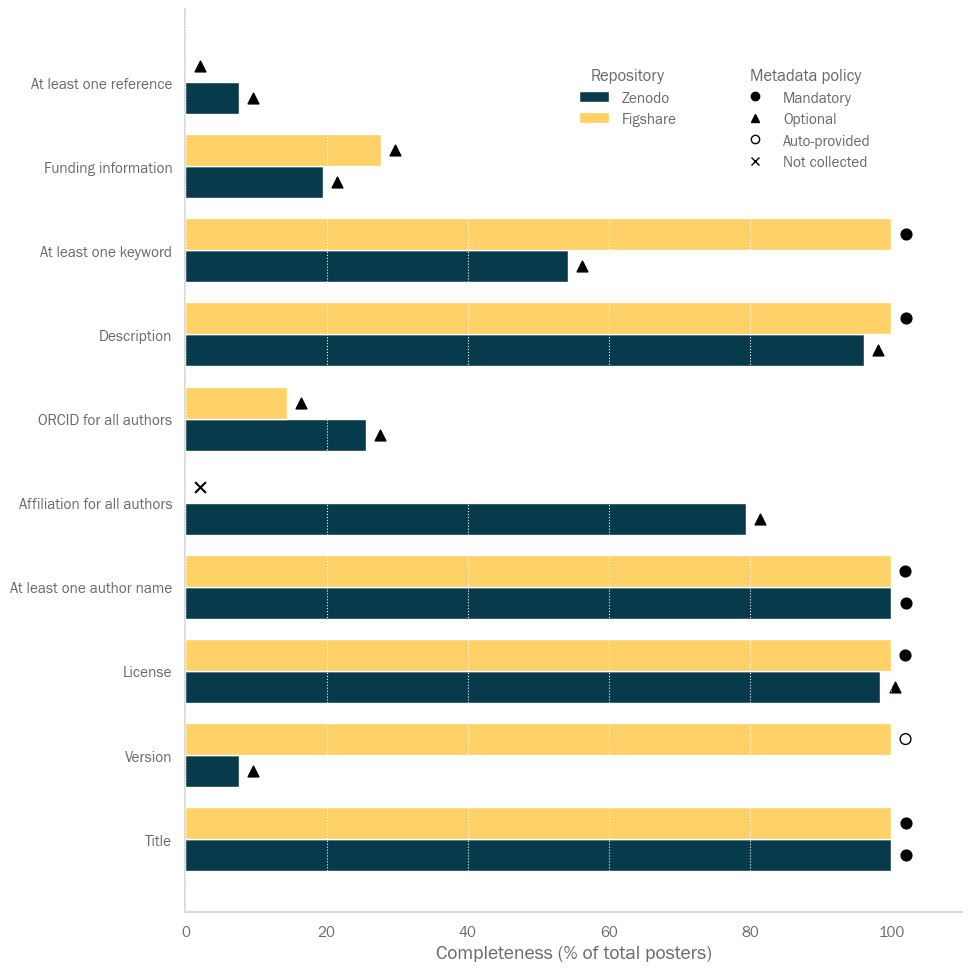

In [99]:
def policy_marker(policy):
    if policy == "mandatory":
        return dict(marker="o", facecolors="black", edgecolors="black")
    if policy == "auto":
        return dict(marker="o", facecolors="none", edgecolors="black") 
    if policy == "not_collected":
        return dict(marker="x", facecolors="black")
    return dict(marker="^", facecolors="black", edgecolors="black")  

def plot_metadata_completeness(df, zenodo_policy, figshare_policy):
    labels = df["Metadata"].tolist()
    z = df["Zenodo"].to_numpy()
    f = df["Figshare"].to_numpy()

    x = np.arange(len(labels))
    width = 0.38

    fig, ax = plt.subplots(figsize=(10, 10))

    # bars
    bz = ax.barh(x - width/2, z, width, label="Zenodo", color = colors[0])
    bf = ax.barh(x + width/2, f, width, label="Figshare", color = colors[1])

    # policy markers
    ypad = 2.0  # % points above bar

    for i, m in enumerate(labels):
        # Zenodo marker
        pz = zenodo_policy.get(m, "optional")
        stylez = policy_marker(pz)
        ax.scatter(min(z[i] + ypad, 102), x[i] - width/2, s=60, **stylez)

        # Figshare marker
        pf = figshare_policy.get(m, "optional")
        stylef = policy_marker(pf)
        ax.scatter(min(f[i] + ypad, 102), x[i] + width/2, s=60, **stylef)

    ax.set_xlim(0, 110)
    ax.set_xlabel("Completeness (% of total posters)", fontsize = 14)
    ax.set_yticks(x)
    ax.set_yticklabels(labels)

    # Repo legend
    bar_legend = ax.legend(
        loc="upper right",
        bbox_to_anchor=(0.65, 0.95),
        title="Repository",
        frameon=False
    )
    ax.add_artist(bar_legend)

    # Policy legend
    from matplotlib.lines import Line2D
    marker_handles = [
        Line2D([0], [0], marker='o', color='black', linestyle='None',
               markerfacecolor='black', label='Mandatory'),
        Line2D([0], [0], marker='^', color='black', linestyle='None',
               markerfacecolor='black', label='Optional'),
        Line2D([0], [0], marker='o', color='black', linestyle='None',
               markerfacecolor='none', label='Auto-provided'),
        Line2D([0], [0], marker='x', color='black', linestyle='None',
               label='Not collected'),
    ]
    ax.legend(handles=marker_handles, loc="center right", title="Repository policy")
    ax.legend(
        handles=marker_handles,
        loc="upper right",
        bbox_to_anchor=(0.9, 0.95),
        title="Metadata policy",
        frameon=False
    )
    ax.grid(axis="x", linestyle=":", linewidth=0.8)
    
    fig.tight_layout()
    return fig, ax


fig, ax = plot_metadata_completeness(df_general_metadata, zenodo_policy, figshare_policy)
plt.savefig('outputs/poster-metadata/completeness.png') 
plt.show()

### Completeness of conference related metadata on Zenodo

Only for Zenodo

In [100]:
conference_metadata_results_list = []

conference_cols = [
    "has_conference_acronym",
    "has_conference_dates",
    "has_conference_place",
    "has_conference_session",
    "has_conference_session_part",
    "has_conference_title",
    "has_conference_website",
]

repository_list = ["Zenodo"] # Only doing this for Zenodo
repository_list_loop = [[x] for x in repository_list]

# Conference name is provided
repo_metadata = ["Conference name"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = len(df_sub[df_sub["has_conference_title"] == True]) / len(df_sub) * 100
    repo_metadata.append(count)
conference_metadata_results_list.append(repo_metadata)

# Conference acronym is provided
repo_metadata = ["Conference acronym"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = len(df_sub[df_sub["has_conference_acronym"] == True]) / len(df_sub) * 100
    repo_metadata.append(count)
conference_metadata_results_list.append(repo_metadata)

# Conference dates are provided
repo_metadata = ["Conference dates"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = len(df_sub[df_sub["has_conference_dates"] == True]) / len(df_sub) * 100
    repo_metadata.append(count)
conference_metadata_results_list.append(repo_metadata)

# Conference location is provided
repo_metadata = ["Conference location"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = len(df_sub[df_sub["has_conference_place"] == True]) / len(df_sub) * 100
    repo_metadata.append(count)
conference_metadata_results_list.append(repo_metadata)

# Conference website is provided
repo_metadata = ["Conference website"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = len(df_sub[df_sub["has_conference_website"] == True]) / len(df_sub) * 100
    repo_metadata.append(count)
conference_metadata_results_list.append(repo_metadata)

# Conference session of the poster is provided
repo_metadata = ["Conference session related to the poster"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(
            df_sub[
                (df_sub["has_conference_session"] == True)
                | (df_sub["has_conference_session_part"] == True)
            ]
        )
        / len(df_sub)
        * 100
    )
    repo_metadata.append(count)
conference_metadata_results_list.append(repo_metadata)

# At least one conference-related metadata is provided
df["has_any_conference_metadata"] = df[conference_cols].any(axis=1)
repo_metadata = ["Any conference-related metadata"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = len(df_sub[df_sub["has_any_conference_metadata"] == True])/ len(df_sub) * 100
    repo_metadata.append(count)
conference_metadata_results_list.append(repo_metadata)

# All conference-related metadata is provided
df["has_all_conference_metadata"] = df[conference_cols].all(axis=1)
repo_metadata = ["All conference-related metadata"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = len(df_sub[df_sub["has_all_conference_metadata"] == True])/ len(df_sub) * 100
    repo_metadata.append(count)
conference_metadata_results_list.append(repo_metadata)

df_conference_metadata = pd.DataFrame(
    conference_metadata_results_list, columns=["Metadata"] + repository_list
)
display(df_conference_metadata)

,Metadata,Zenodo
0,Conference name,47.093070
1,Conference acronym,27.262068
2,Conference dates,44.861324
3,Conference location,40.943640
4,Conference website,37.361527
5,Conference session related to the poster,13.709873
6,Any conference-related metadata,47.566103
7,All conference-related metadata,1.592949


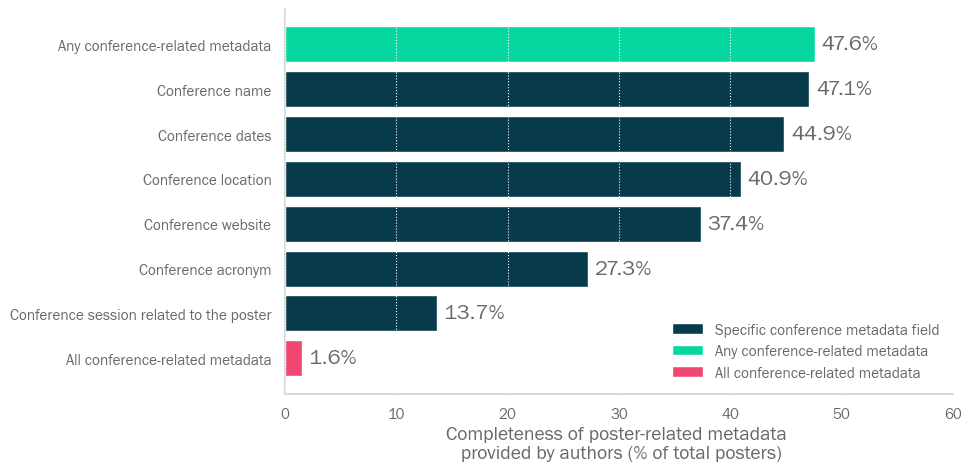

In [101]:
def plot_conference_metadata_zenodo(df_conf):
    dfp = df_conf.copy()

    # Sort by percentage
    dfp = dfp.sort_values("Zenodo", ascending=True).reset_index(drop=True)

    # Rows to highlight with different color
    is_any = dfp["Metadata"].str.strip().eq("Any conference-related metadata")
    is_all = dfp["Metadata"].str.strip().eq("All conference-related metadata")

    # Colors
    base_color = colors[0]      
    any_color = colors[2]       
    all_color = colors[4]      
    colors_assigned = []
    for m in dfp["Metadata"]:
        if m == "Any conference-related metadata":
            colors_assigned.append(any_color)
        elif m == "All conference-related metadata":
            colors_assigned.append(all_color)
        else:
            colors_assigned.append(base_color)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.barh(dfp["Metadata"], dfp["Zenodo"], color=colors_assigned)

    # Add value at the end of bars
    for y, v in enumerate(dfp["Zenodo"].values):
        ax.text(v + 0.6, y, f"{v:.1f}%", va="center")
    
    # Axis
    ax.set_xlim(0, 60)
    ax.set_xlabel("Completeness of poster-related metadata \n provided by authors (% of total posters)",
                 fontsize = 14)

    # Light vertical grid lines over bars
    ax.grid(axis="x", linestyle=":", linewidth=0.8)

    # Legend
    legend_handles = [
    Patch(facecolor=base_color, label="Specific conference metadata field"),
    Patch(facecolor=any_color, label="Any conference-related metadata"),
    Patch(facecolor=all_color, label="All conference-related metadata"),
    ]
    ax.legend(handles=legend_handles, loc="lower right", frameon=False)

    fig.tight_layout()
    return fig, ax

fig, ax = plot_conference_metadata_zenodo(df_conference_metadata)
plt.savefig('outputs/poster-metadata/completeness-conference.png') 
plt.show()